In [1]:
import torch
import torch.nn as nn
from torch import optim
import torchvision.datasets as dset
import torchvision.transforms as transforms

from utils import device_setting, seed_torch
from data_manager import AnomalyDataManager
from model import AutoEncoder, MLP
from metric_layer import ArcMarginProduct
from trainer import AutoEncoderTrainer
# from trainer import Trainer

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import numpy as np
import matplotlib
from statistics import mean

In [10]:
data_dir = '../data'
dataset = 'kdd'
batch_size = 2048
lr = 0.001
momentum = 0.9
max_epoch = 50
criterion = nn.L1Loss(reduction='none')
feature_dim = 5
gpu = 0
device = device_setting(gpu=gpu)
seed = 0
only_normal = True
result_dir = '../results'
model_dir = '../models'
wd = 5e-4

In [11]:
# data_manager = AnomalyDataManager(dataset=dataset, data_dir=data_dir, trans=None, seed=seed, only_normal=only_normal, anomaly_label=9, data_num=2000)
# data_manager = AnomalyDataManager(dataset=dataset, data_dir=data_dir, trans=None, seed=seed, only_normal=only_normal, anomaly_label=anormaly_label, data_num=200)
data_manager = AnomalyDataManager(dataset=dataset, data_dir=data_dir, trans=None, seed=seed, only_normal=only_normal, anomaly_label=9, data_num=200)

# build dataloader
dataloader_dict = data_manager.build_dataloader(batch_size)

# build model, optimizer
channel_in = data_manager.get_channel_in()

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'target', 'level']
dict_keys(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep', 'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back', 'guess_passwd', 'ftp_write', 'multihop', 'rootkit', 'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land', 'loadmodule', 'spy'

In [12]:
dataset_dict = data_manager.get_dataset()
# dataset_dict['train'][0]

In [13]:
len(dataset_dict['test'][:][1][dataset_dict['test'][:][1] == 0])

9711

In [14]:
len(dataset_dict['test'][:][1][dataset_dict['test'][:][1] == 0]) / len(dataset_dict['test'][:][1])

0.43075762952448543

In [15]:
# build dataloader
dataloader_dict = data_manager.build_dataloader(len(dataset_dict['train']))

# build model, optimizer
channel_in = data_manager.get_channel_in()
num_classes = data_manager.get_num_classes()
# model = ResNetMetricModel(channel_in=channel_in, feature_dim=feature_dim, output_dim=num_classes)
# model = ResNet18(num_classes=feature_dim)
model = AutoEncoder(in_dims=data_manager.input_dim, latent_dims=feature_dim, first_dims=32)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [16]:
model = model.to(device)
load_epoch = 49
model_path = '../models/emb_size_'+ str(feature_dim) +'/model_epoch_{}.pth'.format(load_epoch)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [36]:
model.set_threshold(dataloader_dict['train'], criterion, device, thres='max')
model.threshold = 0.03

set Threshold : 4.74831485748291


In [37]:

losses = []
acc = 0
for data, label in dataloader_dict['train']: 
    data = data.to(device)
    label = label.to(device)
    pred_label, loss = model.inference(data, criterion, device)
    losses.append(mean(loss.cpu().detach().tolist()))
    acc += torch.sum(pred_label == label).item()
acc = acc / len(dataloader_dict['train'].dataset)
print(acc)

0.4597765155733749


In [38]:
normal_acc = 0
for data, label in dataloader_dict['test']:
    data = data.to(device)
    label = label.to(device)
    # １以上はすべて異常データ
    label_mask = label != 0
    label[label_mask] = 1
    # label = label.to(device)
    pred_label, loss = model.inference(data, criterion, device)
    losses.append(mean(loss.cpu().detach().tolist()))
    normal_acc += torch.sum(pred_label == label).item()

normal_acc = normal_acc / len(dataloader_dict['test'].dataset)
# plot, print result
print('Test Normal accuracy: {:4f} Test Loss: {:4f} '.format(normal_acc, mean(losses)))

Test Normal accuracy: 0.569242 Test Loss: 0.098507 


In [33]:
tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)

X_embedded = tsne.fit_transform(dataset_dict['test'][:][0].detach().numpy())

C:\Users\matsumoto.yuta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\matsumoto.yuta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [34]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap

In [35]:
X_embedded[:, 0]

array([ 18.380621,  25.772371,  59.226692, ..., -49.53698 , -23.954746,
       -28.05705 ], dtype=float32)

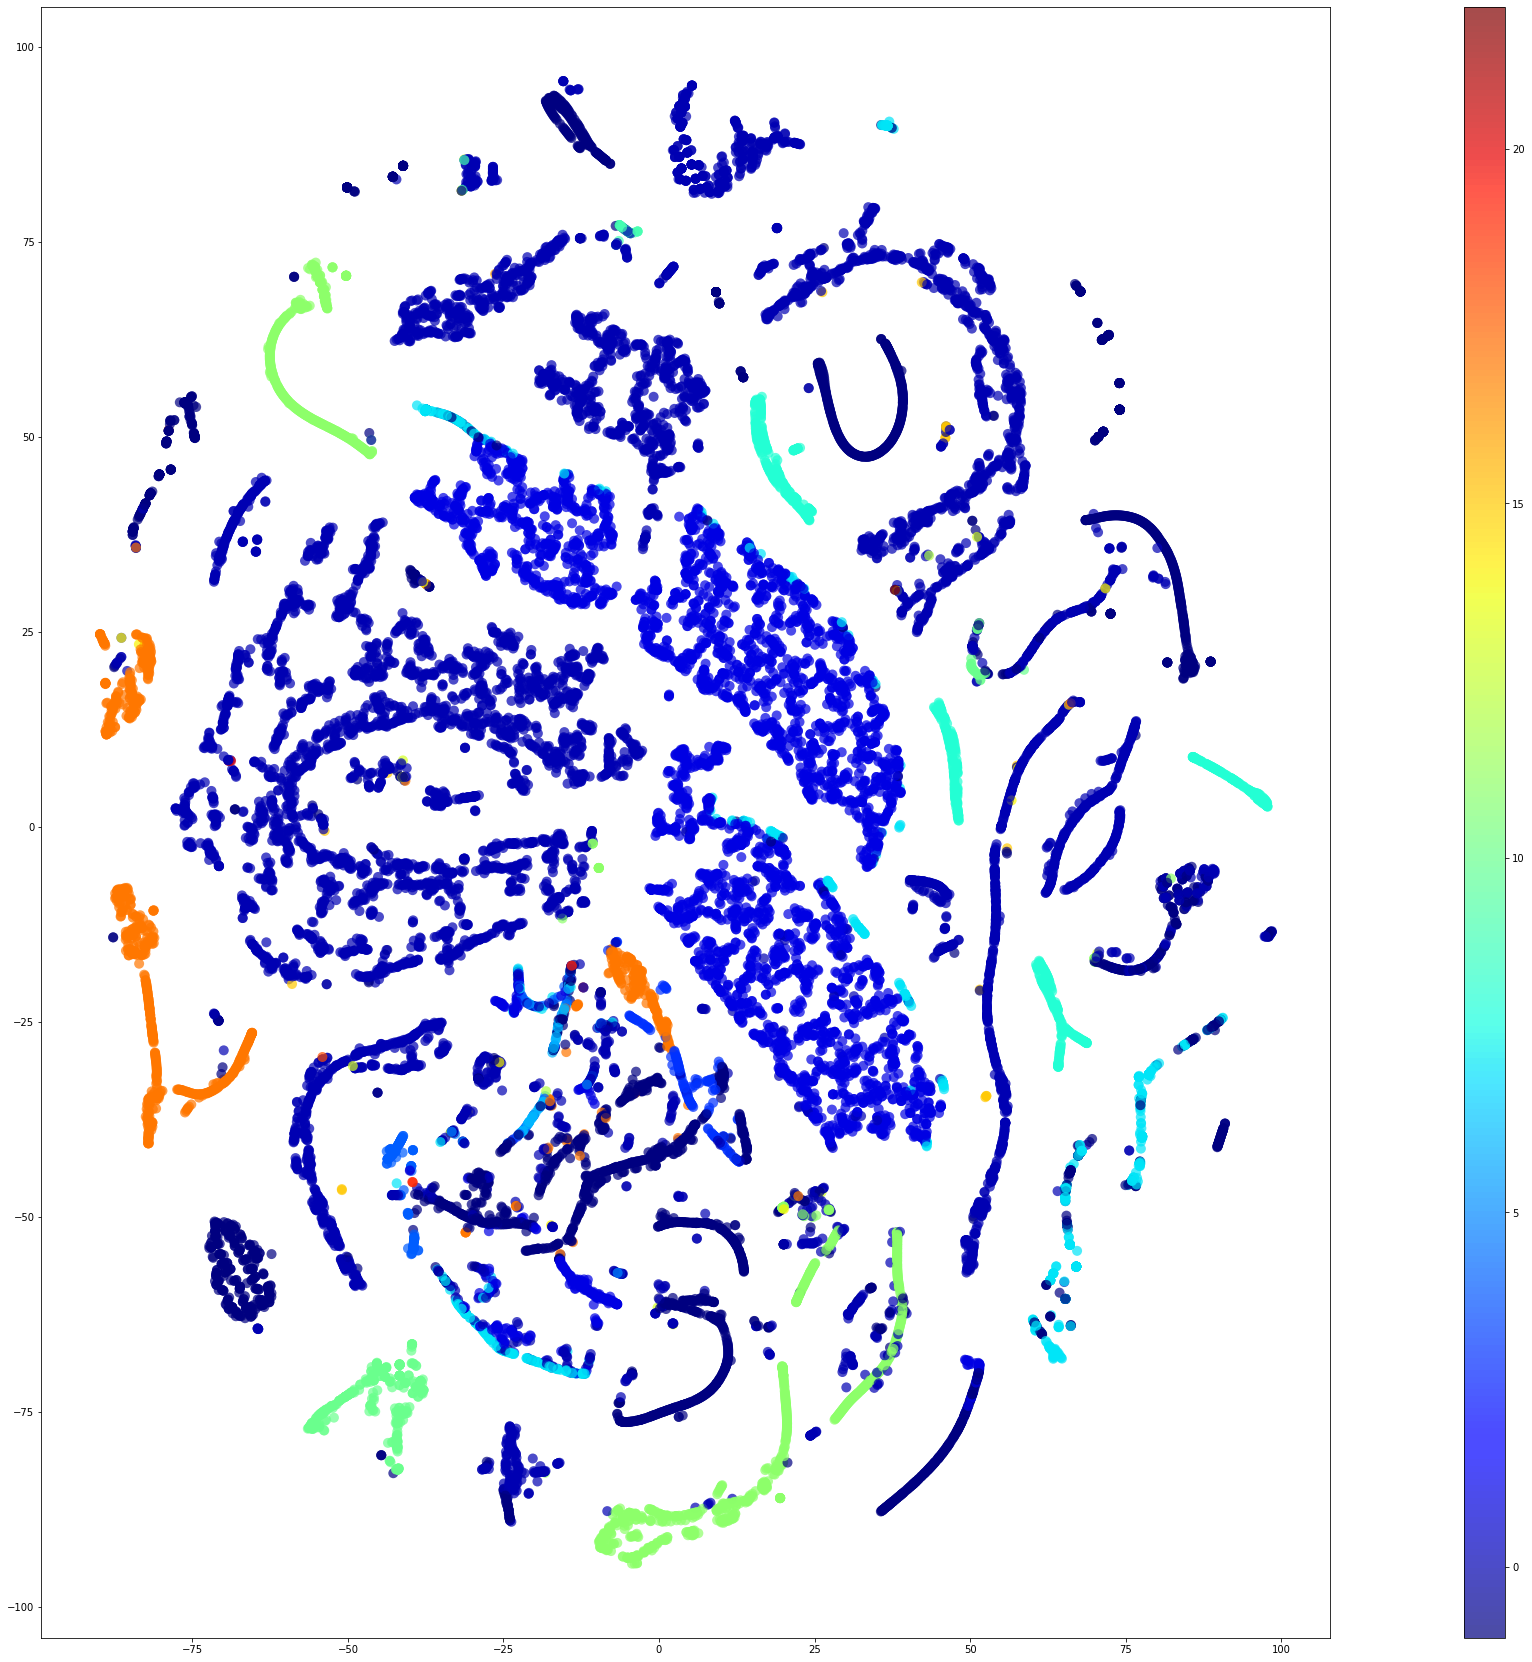

In [36]:
plt.figure(figsize = (30, 30))
# lbl = dataset_dict['train'][:][1][i]
plt.scatter(X_embedded[:, 0], 
            X_embedded[:, 1],
            c=dataset_dict['test'][:][1].detach().numpy(), 
            cmap=plt.cm.jet, 
            edgecolor='none', 
            # label = lbl,
            alpha=0.7,
            s=100)

plt.colorbar(aspect=40, pad=0.08, orientation='vertical')

In [37]:
len(dataset_dict['train'])

53874

In [38]:
# build dataloader
dataloader_dict = data_manager.build_dataloader(len(dataset_dict['train']))

# build model, optimizer
channel_in = data_manager.get_channel_in()
num_classes = data_manager.get_num_classes()
# model = ResNetMetricModel(channel_in=channel_in, feature_dim=feature_dim, output_dim=num_classes)
# model = ResNet18(num_classes=feature_dim)
model = AutoEncoder(in_dims=data_manager.input_dim, latent_dims=feature_dim, first_dims=32)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [39]:
model = model.to(device)

In [84]:
load_epoch = 49
model_path = '../models/emb_size_'+ str(feature_dim) +'/model_epoch_{}.pth'.format(load_epoch)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [85]:
for i, (data, label) in enumerate(dataloader_dict['test']):
    data = data.to(device)
    out, emb = model(data)
    print(i)

0


In [50]:
emb.size()

torch.Size([22544, 5])

In [45]:
tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)

X_embedded = tsne.fit_transform(emb.cpu().detach().numpy())

C:\Users\matsumoto.yuta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\matsumoto.yuta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [46]:
dataset_dict['train'][:][1].detach().numpy()[0]

0

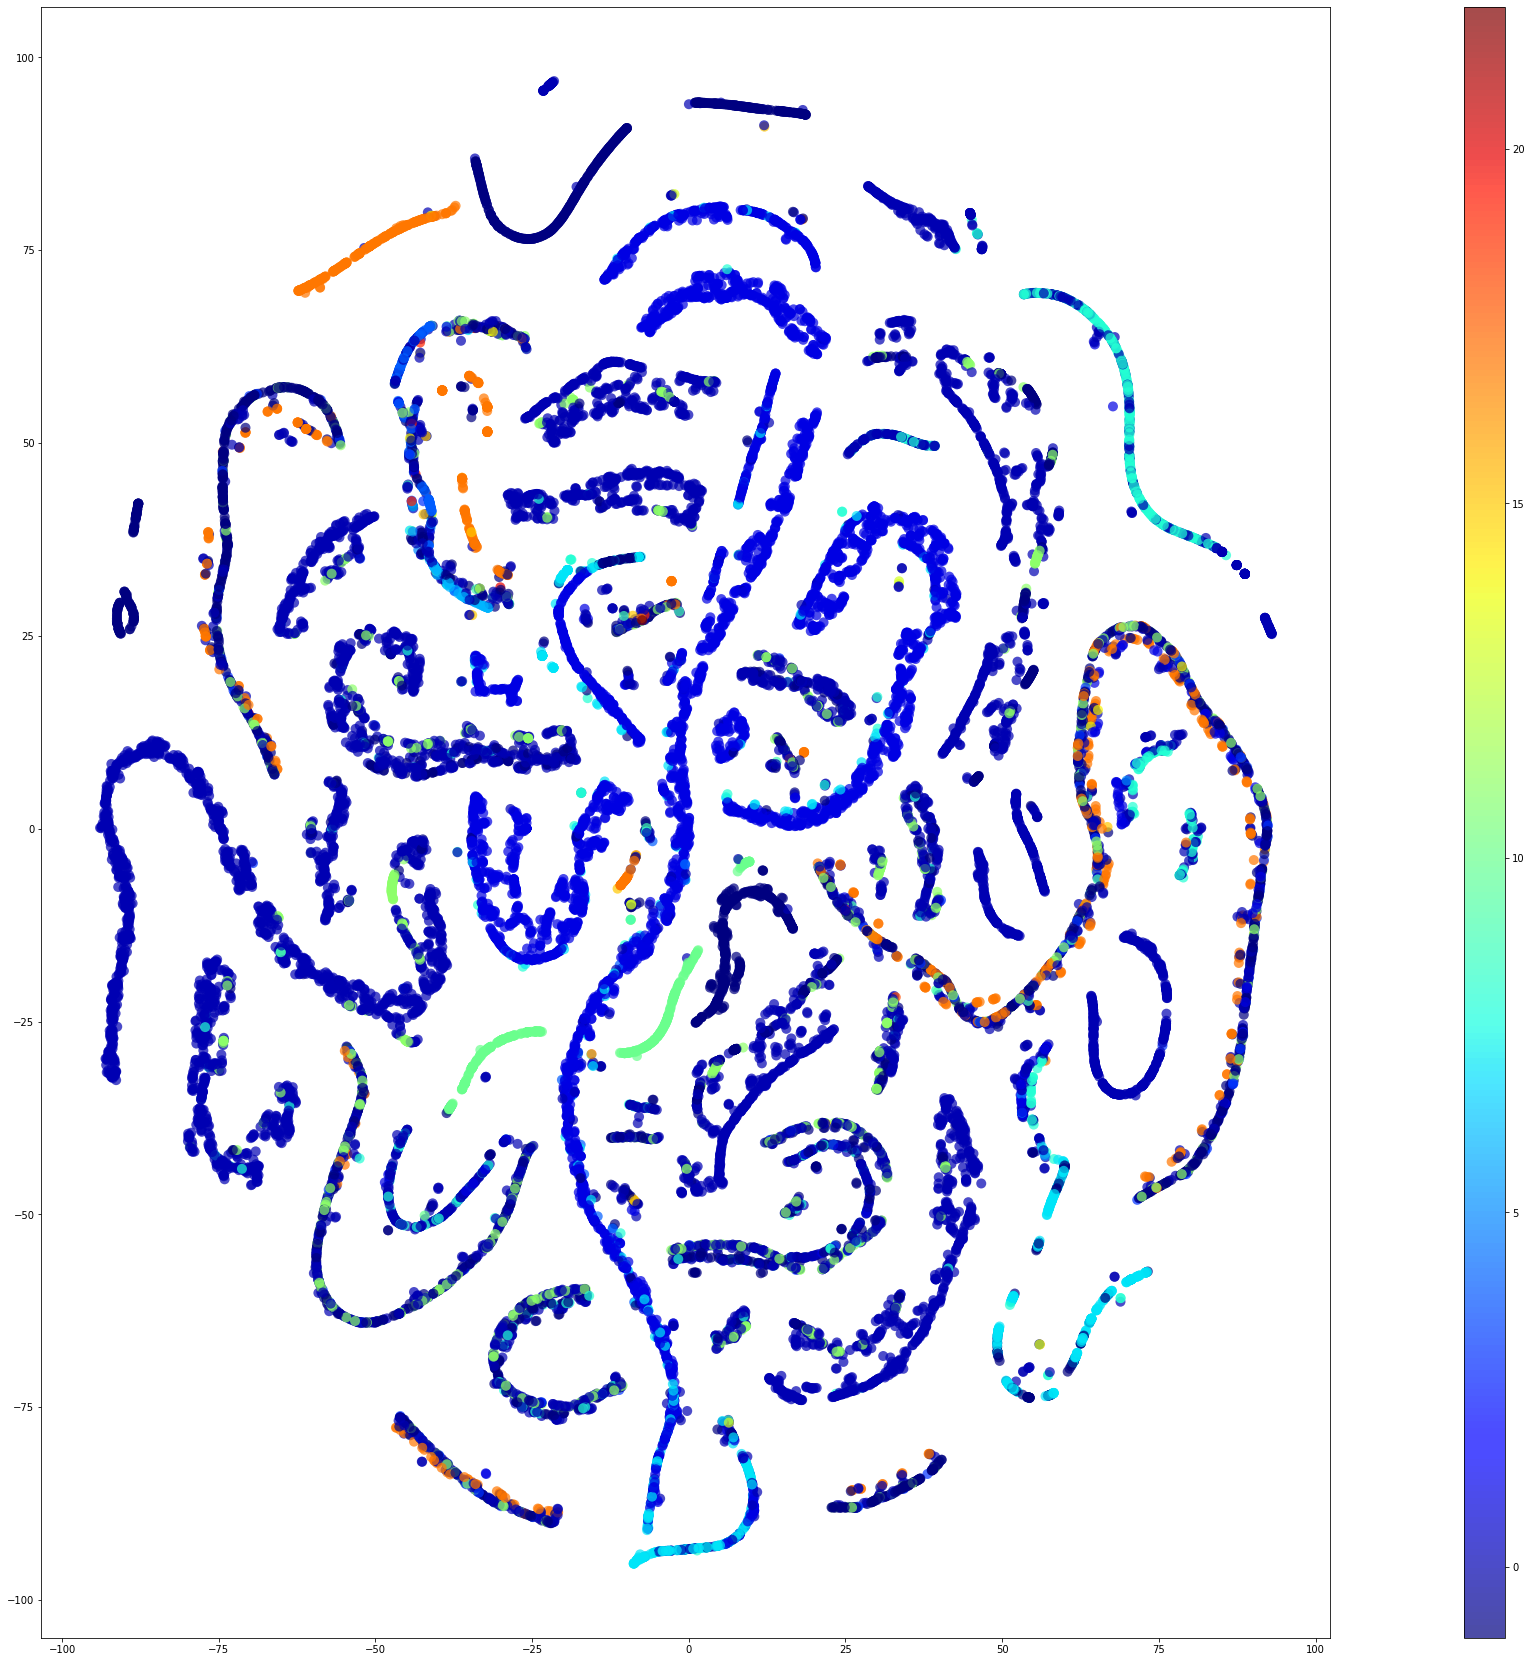

In [47]:
plt.figure(figsize = (30, 30))
# lbl = dataset_dict['train'][:][1][i]
plt.scatter(X_embedded[:, 0], 
            X_embedded[:, 1],
            c=dataset_dict['test'][:][1].detach().numpy(), 
            cmap=plt.cm.jet, 
            edgecolor='none', 
            # label = lbl,
            alpha=0.7,
            s=100)

plt.colorbar(aspect=40, pad=0.08, orientation='vertical')

In [73]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [74]:
emb.shape

torch.Size([22544, 5])

In [78]:
dataset_dict['test'][:][0].detach().numpy().shape

(22544, 122)

In [76]:
pca.fit(emb.cpu().detach().numpy())

PCA(n_components=2)

In [77]:
pca.components_

array([[-0.21354477, -0.30967534, -0.92504615,  0.02438354, -0.04684479],
       [-0.8154713 ,  0.02471945,  0.20881134,  0.40070736, -0.3608695 ]],
      dtype=float32)

In [80]:
pca_transformed = pca.transform(emb.cpu().detach().numpy())

In [81]:
pca_1 = pca_transformed[:, 0]
pca_2 = pca_transformed[:, 1]

In [82]:
pca_1.shape

(22544,)

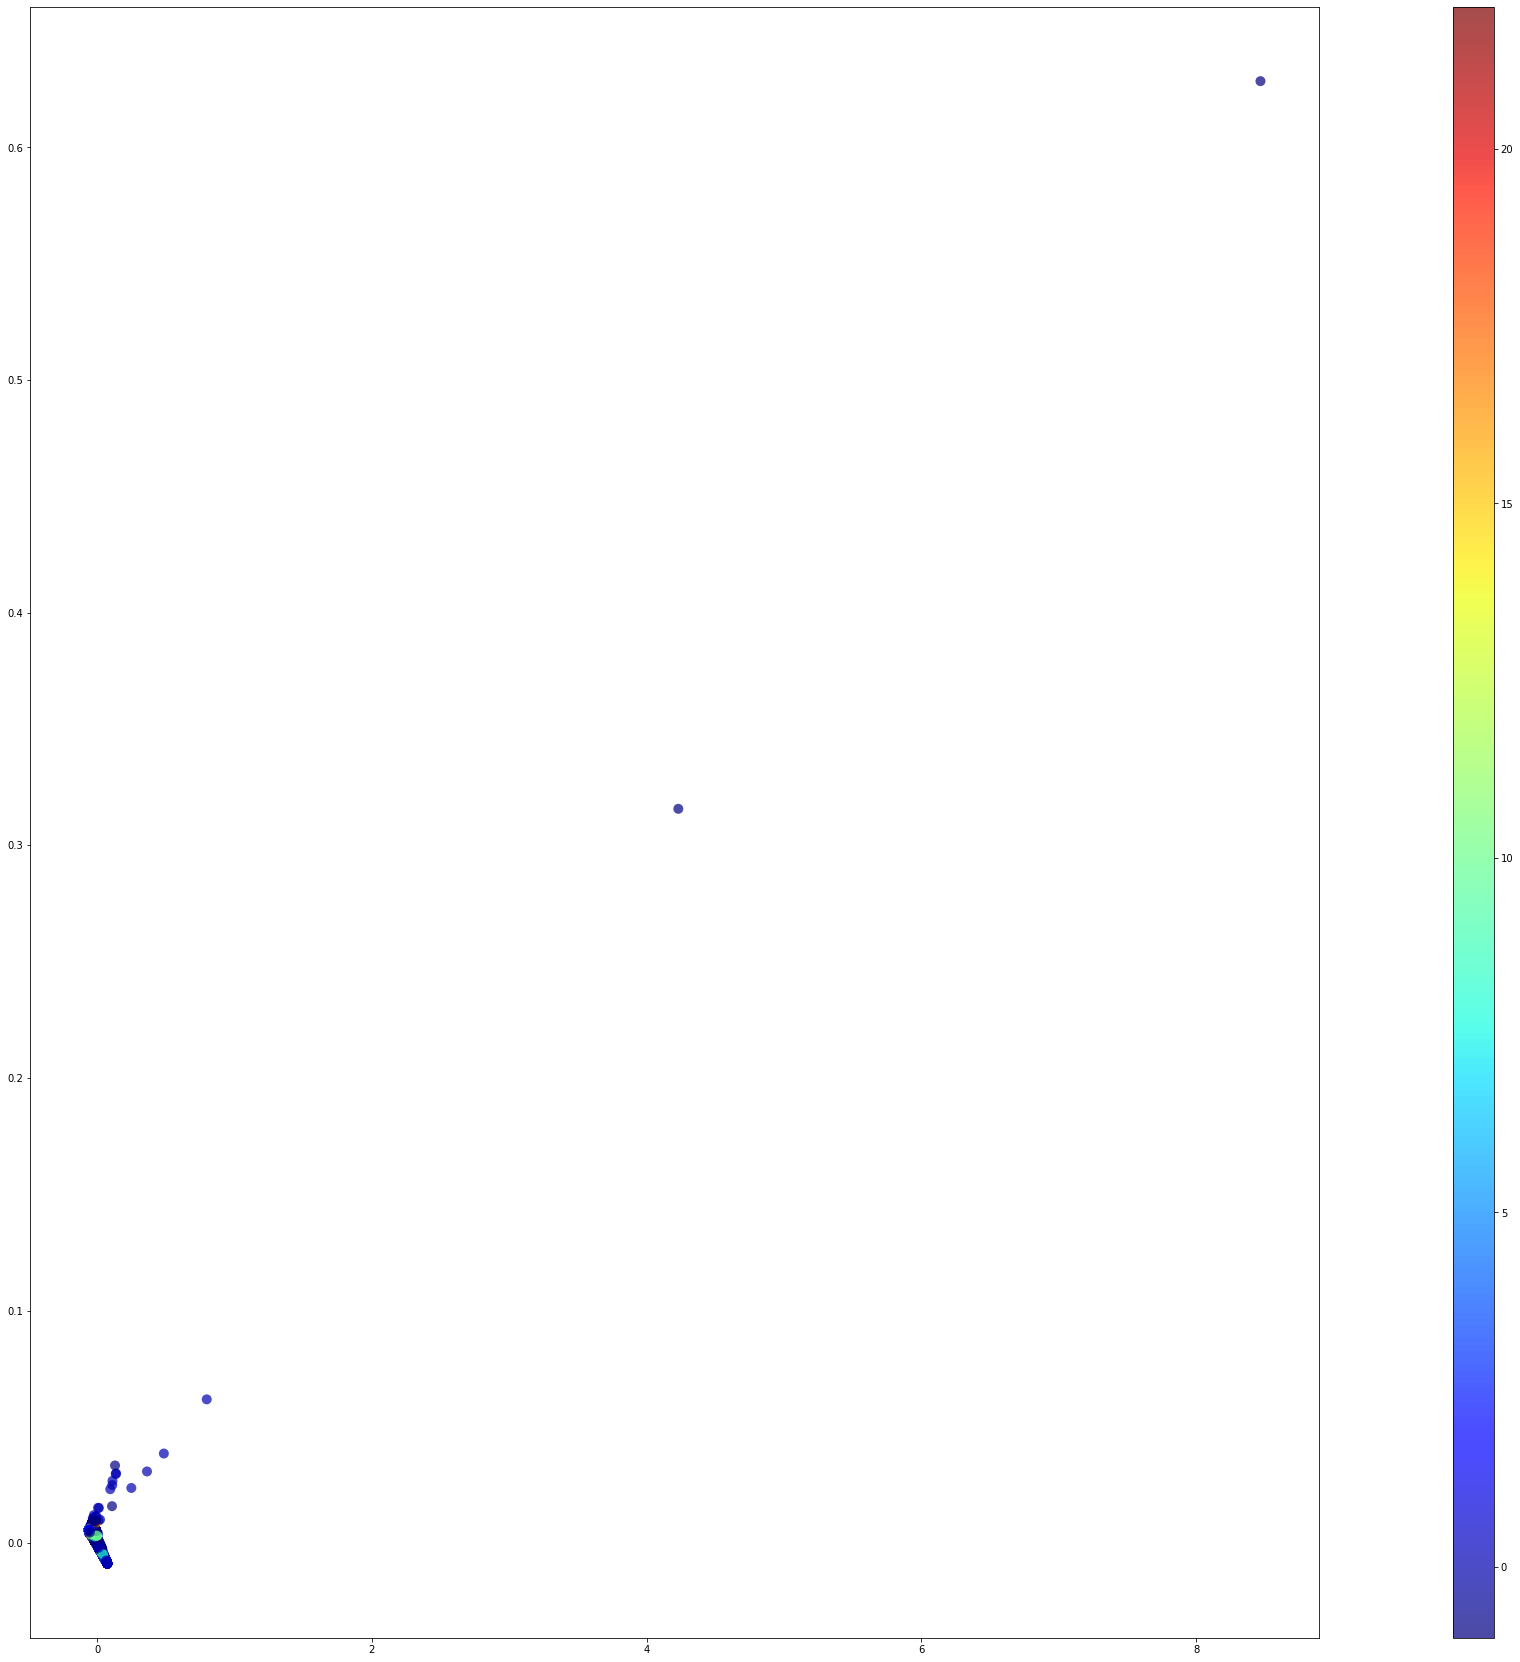

In [83]:
plt.figure(figsize = (30, 30))
# lbl = dataset_dict['train'][:][1][i]
plt.scatter(pca_1, 
            pca_2,
            c=dataset_dict['test'][:][1].detach().numpy(), 
            cmap=plt.cm.jet, 
            edgecolor='none', 
            # label = lbl,
            alpha=0.7,
            s=100)

# plt.xlim(0,1)
# plt.ylim(0,0.1)

plt.colorbar(aspect=40, pad=0.08, orientation='vertical')